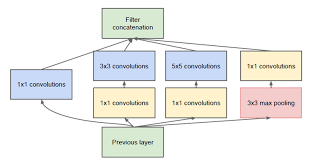
Googlenet Architecture(Inception)

In [1]:
import torch
import torch.nn as nn

In [2]:
class Inception(nn.Module):
    def __init__(self, in_planes,kernel_1_x,
                kernel_3_in,kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        ############### 1x1 conv brance ########################
        # nn,Conv2d(in_dim, out_Dim, filter) stride=1 padding=1        
        self.b1 =nn.Sequential(
        nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
        nn.BatchNorm2d(kernel_1_x),
        nn.ReLU(True),
        )
        ############### 1x1 conv => 3x3 conv brance ########################
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes,kernel_3_in,kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in,kernel_3_x,kernel_size=3,padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )
        ############### 1x1 conv => 3x3 conv => 3x3 conv brance ############
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in,kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in,kernel_5_x,kernel_size=3,padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x,kernel_5_x,kernel_size=3,padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )
        self.b4=nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
    def forward(self,x):
        y1=self.b1(x) #2 64 227 227
        y2=self.b2(x) #2 128 227 227 => y1+y2= 2 192 227 227
        y3=self.b3(x) #2 32 227 227 => y1+y2+y3 = 2 224 227 227
        y4=self.b4(x) #2 32 227 227 => 2 256 227 227
        return torch.cat([y1,y2,y3,y4],1)

In [3]:
def dimension_check():
    net=Inception(3,  64,  96, 128, 16, 32, 32) #=> 2, 4, 5, 6 dim!
    x= torch.randn(2,3,32,32)
    y=net(x)
    print(y.size())

In [4]:
dimension_check()

torch.Size([2, 256, 32, 32])


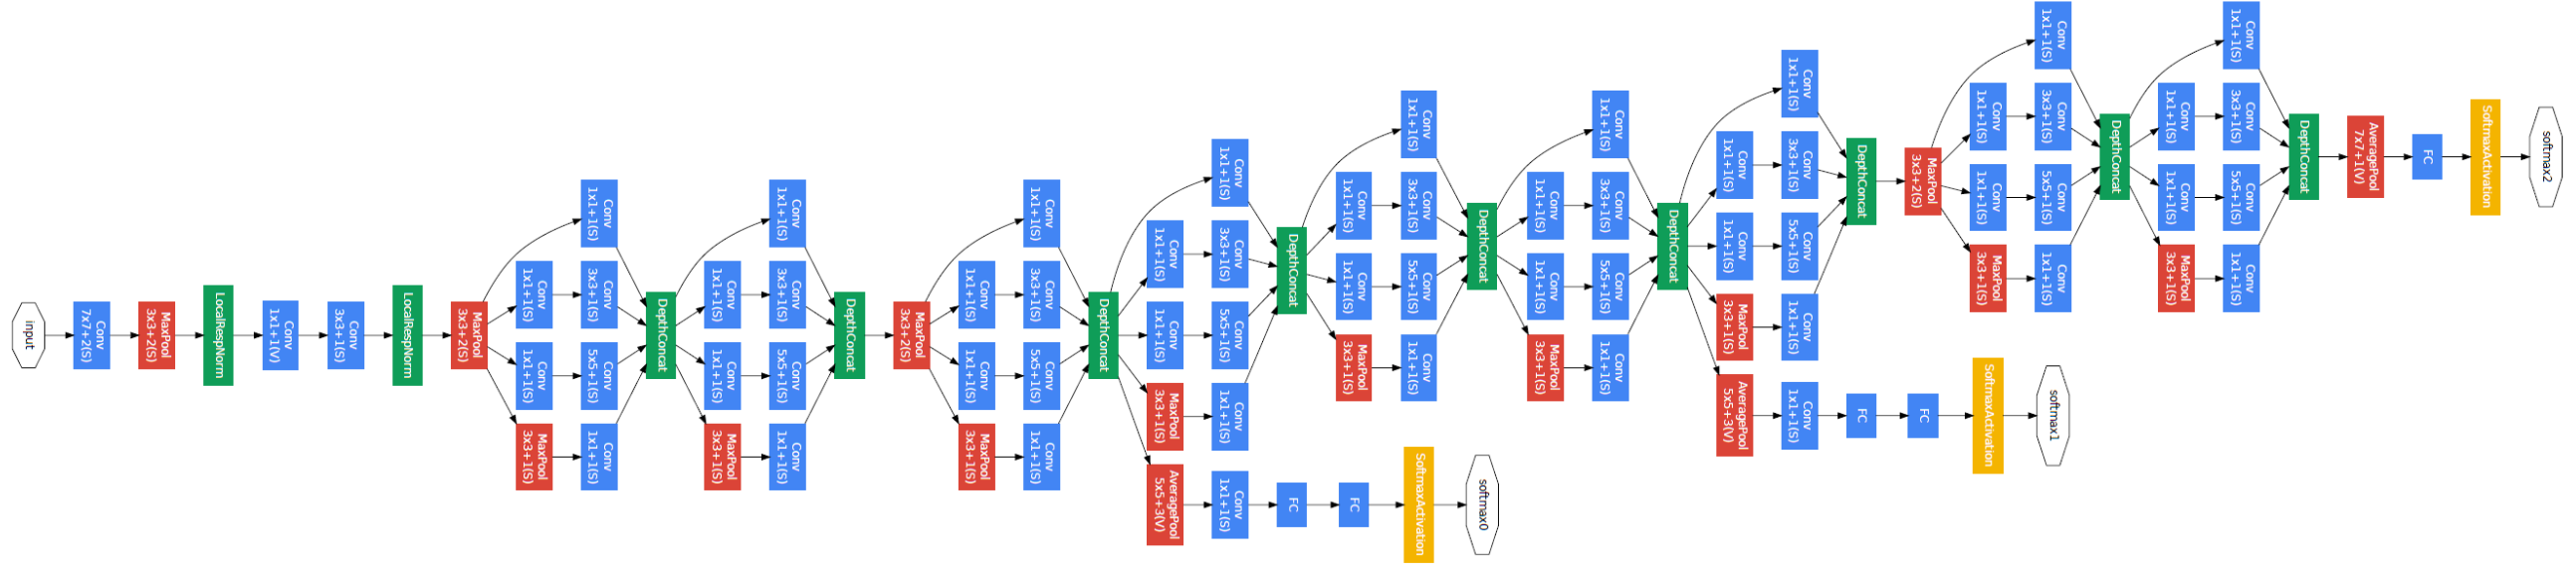

In [5]:
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet,self).__init__()
        self.pre_layers= nn.Sequential(
            nn.Conv2d(3,192,kernel_size=3,padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a3= Inception(192, 64, 96, 128, 16, 32, 32) # 64 128 32 32 = 256
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64) # 128 192 96 64 = 480
        
        self.max_pool = nn.MaxPool2d(3,stride=2,padding=1)
        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)# 192 208 48 64 = 512
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)# 160 224 64 64
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)# 128 256 64 64
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)# 112 288 64 64
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)# 256 320 128 128
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)# 256 320 128 128
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)# 384 384 128 128
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)
        
    def forward(self,x):
        x= self.pre_layers(x)
        x= self.a3(x)       # 2 256 32 32
        x= self.b3(x)       # 2 480 32 32
        x= self.max_pool(x) # 2 480 16 16
        x = self.a4(x)      # 2 512 16 16
        x = self.b4(x)      # 2 512 16 16
        x = self.c4(x)      # 2 512 16 16
        x = self.d4(x)      # 2 528 16 16
        x = self.e4(x)      # 2 832 16 16
        x = self.max_pool(x)# 2 832 8 8
        x = self.a5(x)      # 2 832 8 8
        x = self.b5(x)      # 2 1024 8 8
        x = self.avgpool(x) # 2 1024 1 1
        x = x.view(x.size(0), -1) # 1024
        x = self.linear(x)  # 10
        return x

In [6]:
def dimension_check():
    net=GoogleNet()
    x= torch.randn(1,3,32,32)
    y=net(x)
    print(y.size())

In [7]:
dimension_check()

torch.Size([1, 10])


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt

In [9]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=128,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [10]:
def test(net, partition):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=128, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [11]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=128, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [13]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [14]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
net=GoogleNet()
net.cuda()
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(5):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    train_loss=round(train_loss,2)
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
test_acc = test(net,partition)
test_acc=round(test_acc,2)

  0%|          | 0/313 [00:00<?, ?it/s]

time : 90.89, train_loss : 1.39, train_acc : 48.27,val_acc : 51.96,val_loss : 1.35


  0%|          | 0/313 [00:00<?, ?it/s]

time : 91.95, train_loss : 0.91, train_acc : 67.68,val_acc : 67.41,val_loss : 0.93


  0%|          | 0/313 [00:00<?, ?it/s]

time : 92.46, train_loss : 0.70, train_acc : 75.52,val_acc : 69.59,val_loss : 0.94


  0%|          | 0/313 [00:00<?, ?it/s]

time : 92.66, train_loss : 0.57, train_acc : 80.22,val_acc : 74.79,val_loss : 0.74


  0%|          | 0/79 [00:00<?, ?it/s]

time : 93.01, train_loss : 0.49, train_acc : 83.10,val_acc : 78.56,val_loss : 0.63


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]
